# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Overview & Cleaning

## Portfolio

In [2]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [5]:
portfolio.groupby('offer_type').size()

offer_type
bogo             4
discount         4
informational    2
dtype: int64

In [6]:
portfolio.groupby('offer_type').mean()

reward  difficulty  duration
offer_type                                 
bogo              7.5        7.50       6.0
discount          3.0       11.75       8.5
informational     0.0        0.00       3.5

In [7]:
# Change duration into hours
portfolio['duration'] = portfolio['duration']*24

# One hot encoding
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio.drop('channels', axis=1, inplace=True)

In [8]:
portfolio = portfolio.rename(columns={'id':'offer_id'})
offer_id = portfolio.offer_id.astype('category').cat.categories.tolist()
label_offer_id = {'offer_id':{o:v for o,v in zip(offer_id, list(range(1,len(offer_id)+1)))}}
portfolio.replace(label_offer_id, inplace=True)

In [9]:
def type_group(df, column):
    df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column],prefix_sep = '_', prefix=column)], axis=1)
    return df
portfolio = type_group(portfolio, 'offer_type')

In [10]:
portfolio

reward  difficulty  duration  offer_id  email  mobile  web  \
0      10          10       168         8      1       1    0   
1      10          10       120         5      1       1    1   
2       0           0        96         4      1       1    1   
3       5           5       168         7      1       1    1   
4       5          20       240         1      1       0    1   
5       3           7       168         2      1       1    1   
6       2          10       240        10      1       1    1   
7       0           0        72         6      1       1    0   
8       5           5       120         9      1       1    1   
9       2          10       168         3      1       1    1   

   offer_type_bogo  offer_type_discount  offer_type_informational  
0                1                    0                         0  
1                1                    0                         0  
2                0                    0                         1  
3                1                    0                         0  
4                0                    1                         0  
5                0                    1                         0  
6                0                    1                         0  
7                0                    0                         1  
8                1                    0                         0  
9                0                    1                         0

## Profile

In [11]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [12]:
profile.shape

(17000, 5)

In [13]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile[(profile['age'] != 118)].isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [15]:
profile.groupby('gender').size()

gender
F    6129
M    8484
O     212
dtype: int64

In [16]:
# drop every gender with missing value and 'other' gender
profile.dropna(inplace=True, axis=0, how='any')
profile = profile[profile['gender'] != 'O']

In [17]:
profile.describe()

age  became_member_on         income
count  14613.000000      1.461300e+04   14613.000000
mean      54.393417      2.016687e+07   65435.707931
std       17.400201      1.189517e+04   21633.524110
min       18.000000      2.013073e+07   30000.000000
25%       42.000000      2.016052e+07   49000.000000
50%       55.000000      2.017080e+07   64000.000000
75%       66.000000      2.017123e+07   80000.000000
max      101.000000      2.018073e+07  120000.000000

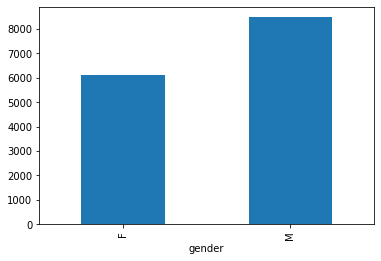

In [18]:
profile.groupby('gender').size().sort_values().plot(kind='bar')

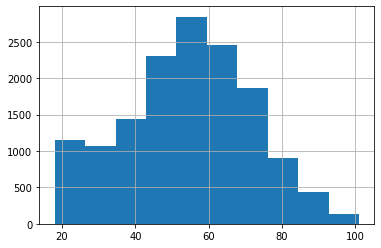

In [19]:
profile.age.hist(bins=10)

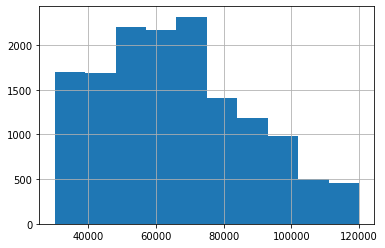

In [20]:
profile.income.hist()

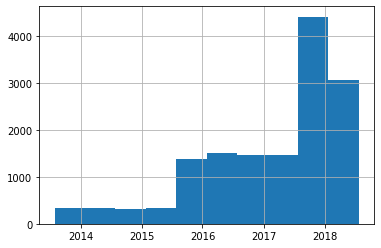

In [21]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d', infer_datetime_format=True)
profile['became_member_on'].hist()

In [22]:
def add_time_variable(df, column):
    for vars in ['weekday','month','year']:
        df[str(column) + '_' + vars] = getattr(df[column].dt,vars)
    df = df.drop(column, axis=1)
    return df
profile = add_time_variable(profile, 'became_member_on')

def time_group(df, columns):
    for column in columns:
        df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column],prefix_sep = '_', prefix=column)], axis=1)
    return df
columns = ['became_member_on_weekday','became_member_on_month','became_member_on_year']
profile = time_group(profile, columns)

In [23]:
def age_group(df, column):
    df['age_group'] = pd.cut(df[column], bins=[17, 25, 40, 60, 101], labels = ['young_adult','adult','middle_age_adult','eldery'])
    df = pd.concat([df.drop('age_group', axis=1), pd.get_dummies(df['age_group'])], axis=1)
    df = df.drop(column, axis=1)
    return df
profile = age_group(profile, 'age')

In [24]:
def income_group(df, column):
    min_inc = df[column].min()
    mean_inc = df[column].mean()
    quartile_third_inc = df[column].describe()[6]
    max_inc = df[column].max()
    df['income_group'] = pd.cut(df[column], bins=[min_inc, mean_inc, quartile_third_inc, max_inc], labels = ['low','medium','high'])
    df = pd.concat([df.drop('income_group', axis=1), pd.get_dummies(df['income_group'],prefix_sep = '_', prefix=column)], axis=1)
    df.drop('income', axis=1, inplace=True)
    return df
profile = income_group(profile, 'income')

In [25]:
def type_group(df, column):
    df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column],prefix_sep = '_', prefix=column)], axis=1)
    return df
profile = type_group(profile, 'gender')

In [26]:
profile = profile.rename(columns={'id':'customer_id'})
customer_id = profile.customer_id.astype('category').cat.categories.tolist()
label_customer_id = {'customer_id':{c:v for c,v in zip(customer_id, list(range(1,len(customer_id)+1)))}}
profile.replace(label_customer_id, inplace=True)

In [27]:
profile.head()

customer_id  became_member_on_weekday_0  became_member_on_weekday_1  \
1           340                           0                           0   
3          6856                           0                           1   
5         12925                           0                           0   
8          3191                           0                           0   
12         2626                           0                           0   

    became_member_on_weekday_2  became_member_on_weekday_3  \
1                            0                           0   
3                            0                           0   
5                            0                           1   
8                            0                           0   
12                           0                           0   

    became_member_on_weekday_4  became_member_on_weekday_5  \
1                            0                           1   
3                            0                           0   
5                            0                           0   
8                            1                           0   
12                           0                           1   

    became_member_on_weekday_6  became_member_on_month_1  \
1                            0                         0   
3                            0                         0   
5                            0                         0   
8                            0                         0   
12                           0                         0   

    became_member_on_month_2  ...  became_member_on_year_2018  young_adult  \
1                          0  ...                           0            0   
3                          0  ...                           0            0   
5                          0  ...                           1            0   
8                          1  ...                           1            0   
12                         0  ...                           0            0   

    adult  middle_age_adult  eldery  income_low  income_medium  income_high  \
1       0                 1       0           0              0            1   
3       0                 0       1           0              0            1   
5       0                 0       1           0              1            0   
8       0                 0       1           1              0            0   
12      0                 1       0           1              0            0   

    gender_F  gender_M  
1          1         0  
3          1         0  
5          0         1  
8          0         1  
12         0         1  

[5 rows x 35 columns]

## Transcript

In [28]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [29]:
transcript.shape

(306534, 4)

In [30]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [31]:
transcript.groupby('event').size()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
dtype: int64

In [32]:
received = transcript[transcript['event'] == 'offer received']
viewed = transcript[transcript['event'] == 'offer viewed']
completed = transcript[transcript['event'] == 'offer completed']
transaction = transcript[transcript['event'] == 'transaction']

In [33]:
received.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [34]:
viewed.head()

person         event  \
12650  389bc3fa690240e798340f5a15918d5c  offer viewed   
12651  d1ede868e29245ea91818a903fec04c6  offer viewed   
12652  102e9454054946fda62242d2e176fdce  offer viewed   
12653  02c083884c7d45b39cc68e1314fec56c  offer viewed   
12655  be8a5d1981a2458d90b255ddc7e0d174  offer viewed   

                                                  value  time  
12650  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
12651  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}     0  
12652  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
12653  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}     0  
12655  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}     0

In [35]:
completed.head()

person            event  \
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed   
12672  fe97aa22dd3e48c8b143116a8403dd52  offer completed   
12679  629fc02d56414d91bca360decdfa9288  offer completed   
12692  676506bad68e4161b9bbaffeb039626b  offer completed   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed   

                                                   value  time  
12658  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...     0  
12672  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...     0  
12679  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...     0  
12692  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...     0  
12697  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...     0

In [36]:
transaction.head()

person        event  \
12654  02c083884c7d45b39cc68e1314fec56c  transaction   
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  transaction   
12659  54890f68699049c2a04d415abc25e717  transaction   
12670  b2f1cd155b864803ad8334cdf13c4bd2  transaction   
12671  fe97aa22dd3e48c8b143116a8403dd52  transaction   

                                value  time  
12654  {'amount': 0.8300000000000001}     0  
12657               {'amount': 34.56}     0  
12659               {'amount': 13.23}     0  
12670               {'amount': 19.51}     0  
12671               {'amount': 18.97}     0

In [37]:
def transform_df_offer(df,column):
    df = pd.concat([df.drop(column, axis=1), df[column].apply(pd.Series)], axis=1)
    df = df.rename(columns={'person':'customer_id', 'offer id':'offer_id'})
    df.replace(label_customer_id, inplace=True)
    df.replace(label_offer_id, inplace=True)
    return df

received = transform_df_offer(received, 'value')
viewed = transform_df_offer(viewed, 'value')
completed = transform_df_offer(completed, 'value')

def transform_df_amount(df,column):
    df = pd.concat([df.drop(column, axis=1), df[column].apply(pd.Series)], axis=1)
    df = df.rename(columns={'person':'customer_id'})
    df.replace(label_customer_id, inplace=True)
    return df

transaction = transform_df_amount(transaction, 'value')

In [38]:
received = received.rename(columns={'time':'time_received','event':'offer_received'})
received.head()

customer_id  offer_received  time_received  offer_id
0                              6856  offer received              0         7
1  a03223e636434f42ac4c3df47e8bac43  offer received              0         1
2                             12925  offer received              0         3
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received              0        10
4  68617ca6246f4fbc85e91a2a49552598  offer received              0         5

In [39]:
viewed = viewed.rename(columns={'time':'time_viewed','event':'offer_viewed'})
viewed.head()

customer_id  offer_viewed  time_viewed  offer_id
12650                              3191  offer viewed            0         9
12651  d1ede868e29245ea91818a903fec04c6  offer viewed            0         6
12652                               904  offer viewed            0         5
12653                               145  offer viewed            0         8
12655                             10951  offer viewed            0         6

In [40]:
completed = completed.rename(columns={'time':'time_completed','event':'offer_completed'})
completed.head()

customer_id  offer_completed  time_completed  offer_id  reward
12658        9195  offer completed               0         3       2
12672       14531  offer completed               0        10       2
12679        5620  offer completed               0         7       5
12692        5900  offer completed               0         8      10
12697        8220  offer completed               0         5      10

In [41]:
transaction = transaction.rename(columns={'time':'time_transaction','event':'transaction'})
transaction.head()

customer_id  transaction  time_transaction  amount
12654         145  transaction                 0    0.83
12657        9195  transaction                 0   34.56
12659        4847  transaction                 0   13.23
12670       10298  transaction                 0   19.51
12671       14531  transaction                 0   18.97

# Model 1: Offer Viewed and Completed Prediction
Which customer in certain demographic group will viewed and/or completed the offer that they received? 

## Data Preparation
Merging between received, profile, portfolio and completed datasets.

In [42]:
df_merge = pd.merge(received, profile, how='inner', on='customer_id')
df_merge = pd.merge(df_merge, portfolio, how='inner', on='offer_id')
df_merge = pd.merge(df_merge, viewed, how='left', on=['offer_id','customer_id'])
df_merge = pd.merge(df_merge, completed.drop('reward', axis=1), how='left', on=['offer_id','customer_id'])
df_merge['offer_viewed'] = df_merge['offer_viewed'].apply(lambda x: 0 if pd.isnull(x) else 1)
df_merge['offer_completed'] = df_merge['offer_completed'].apply(lambda x: 0 if pd.isnull(x) else 1)

# removed unnecessary duplications and cleaning wrong label of offer viewed and offer cleaned
df_merge['duration_expired'] = df_merge['time_received'] + df_merge['duration'] 
df_merge['time_viewed'] = df_merge['time_viewed'].apply(lambda x: 0 if pd.isnull(x) else x)
df_merge['time_completed'] = df_merge['time_completed'].apply(lambda x: 0 if pd.isnull(x) else x)
df_merge['offer_viewed'] = np.where((df_merge['time_viewed'] < df_merge['time_received']) | (df_merge['time_viewed'] > df_merge['duration_expired']),0,df_merge['offer_viewed'])
df_merge['offer_completed'] = np.where((df_merge['time_completed'] < df_merge['time_received']) | (df_merge['time_completed'] > df_merge['duration_expired']),0,df_merge['offer_completed'])
df_merge = df_merge.drop_duplicates(['customer_id','time_received','offer_id'])
df_merge.head()

customer_id  offer_received  time_received  offer_id  \
0        6856  offer received              0         7   
1       12925  offer received            408         7   
2        3191  offer received            168         7   
4        3191  offer received            408         7   
6       11914  offer received            504         7   

   became_member_on_weekday_0  became_member_on_weekday_1  \
0                           0                           1   
1                           0                           0   
2                           0                           0   
4                           0                           0   
6                           0                           0   

   became_member_on_weekday_2  became_member_on_weekday_3  \
0                           0                           0   
1                           0                           1   
2                           0                           0   
4                           0                           0   
6                           0                           0   

   became_member_on_weekday_4  became_member_on_weekday_5  ...  mobile  web  \
0                           0                           0  ...       1    1   
1                           0                           0  ...       1    1   
2                           1                           0  ...       1    1   
4                           1                           0  ...       1    1   
6                           0                           1  ...       1    1   

   offer_type_bogo  offer_type_discount  offer_type_informational  \
0                1                    0                         0   
1                1                    0                         0   
2                1                    0                         0   
4                1                    0                         0   
6                1                    0                         0   

   offer_viewed  time_viewed  offer_completed  time_completed  \
0             1          6.0                1           132.0   
1             1        420.0                1           522.0   
2             1        192.0                0           498.0   
4             0        192.0                1           498.0   
6             1        522.0                0             0.0   

   duration_expired  
0               168  
1               576  
2               336  
4               576  
6               672  

[5 rows x 52 columns]

## Exploratory Data Analysis

In [315]:
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
style.use('seaborn-poster')
style.use('seaborn-white')

Text(0.5, 1.0, 'Number of Offer Viewed')

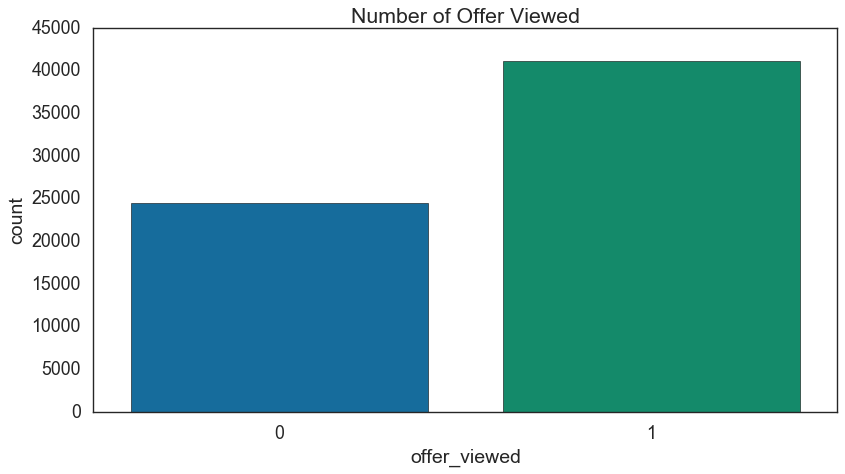

In [293]:
plt.figure(figsize=[12,6])
sns.countplot(df_merge['offer_viewed'])
plt.title('Number of Offer Viewed')

Text(0.5, 1.0, 'Number of Offer Completed')

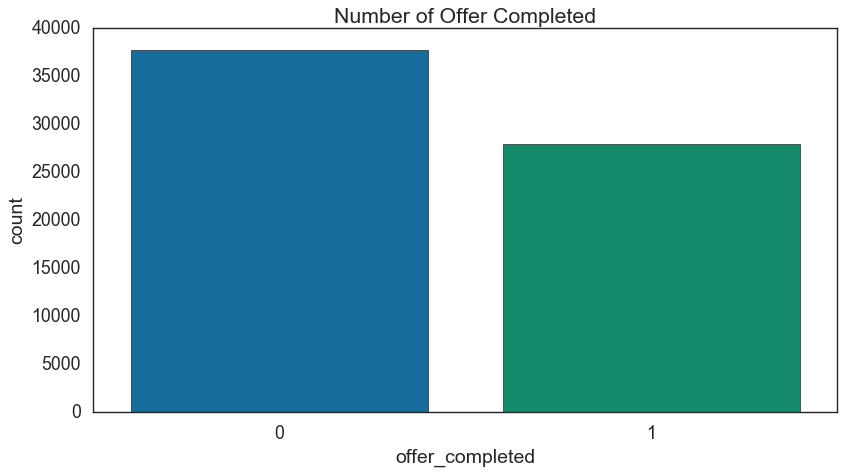

In [484]:
plt.figure(figsize=[12,6])
sns.countplot(df_merge['offer_completed'])
plt.title('Number of Offer Completed')

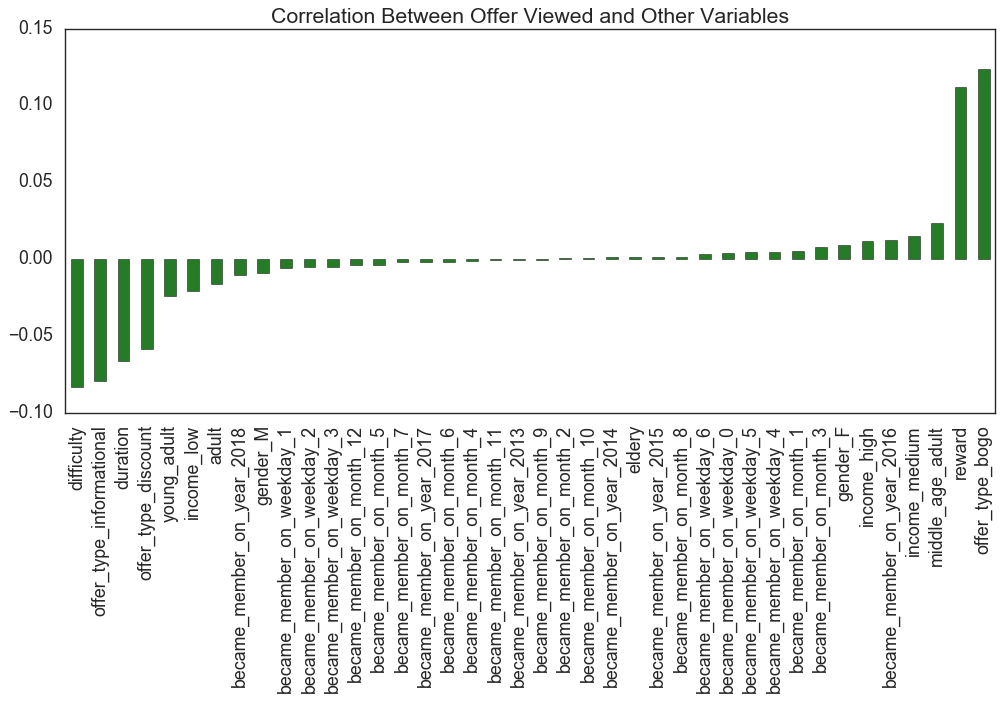

In [289]:
plt.figure(figsize=[15,6])
plt.title('Correlation Between Offer Viewed and Other Variables')
df_merge.drop(['email','web','mobile','offer_received','time_received','time_viewed','time_completed','customer_id','offer_id','offer_completed','duration_expired'],axis=1)\
.corr()['offer_viewed'].sort_values().drop('offer_viewed').plot(kind='bar',color = 'darkgreen', alpha = 0.85)
plt.savefig("correlation_viewed.png", bbox_inches='tight', dpi=600)

In [304]:
def with_hue(plot, feature, Number_of_categories, hue_categories, filename):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 1.4 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height()
            ax.annotate(percentage, (x, y), size = 16,  weight='bold')
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.show()

def without_hue(plot, feature, filename):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 16,  weight='bold')
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.show()

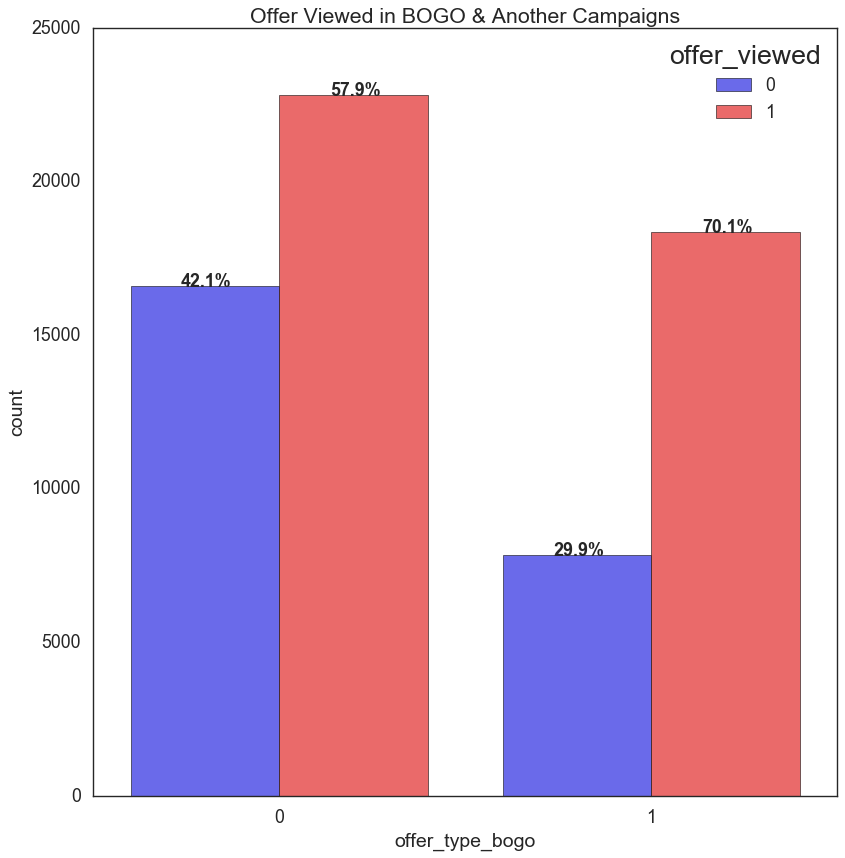

In [308]:
plt.figure(figsize=[12,12])
plt.title('Offer Viewed in BOGO & Another Campaigns')
ax = sns.countplot(x=df_merge.offer_type_bogo, hue =df_merge.offer_viewed,palette='seismic')
sns.set_context("poster")
with_hue(ax,df_merge.offer_type_bogo,2,2,'bogo_viewed.png')

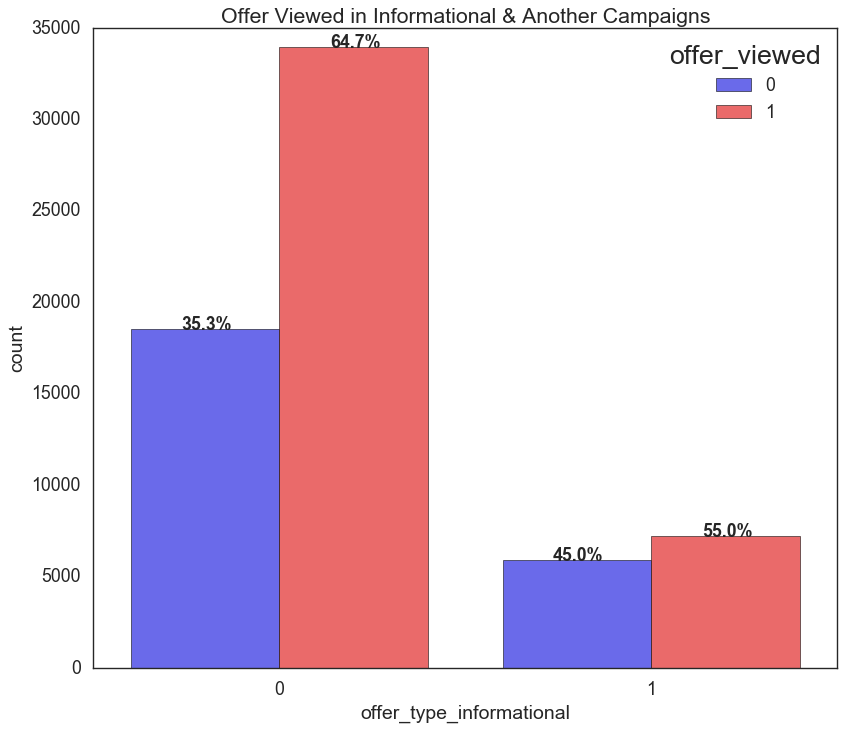

In [316]:
plt.figure(figsize=[12,10])
plt.title('Offer Viewed in Informational & Another Campaigns')
ax = sns.countplot(x=df_merge.offer_type_informational, hue =df_merge.offer_viewed, palette='seismic')
with_hue(ax,df_merge.offer_type_informational,2,2,'inform_viewed.png')

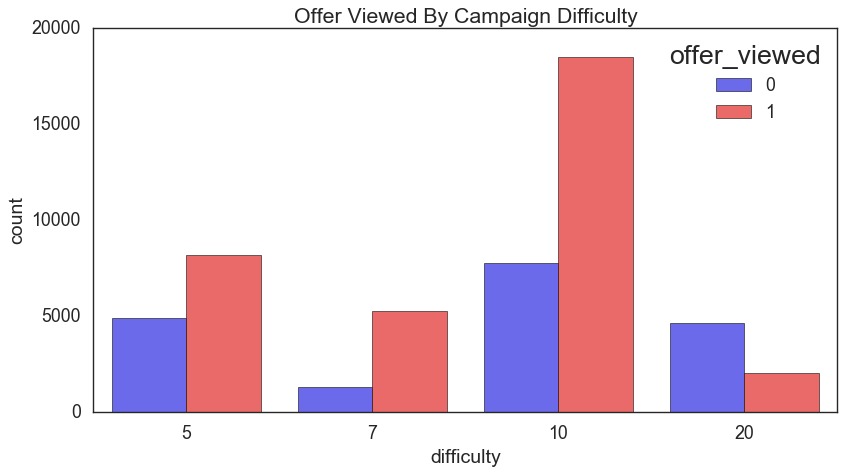

In [322]:
plt.figure(figsize=[12,6])
plt.title('Offer Viewed By Campaign Difficulty')
sns.countplot(x=df_merge.difficulty[df_merge['difficulty'] > 0], hue =df_merge.offer_viewed, palette='seismic')
plt.savefig('difficulty_viewed', bbox_inches='tight', dpi=600)

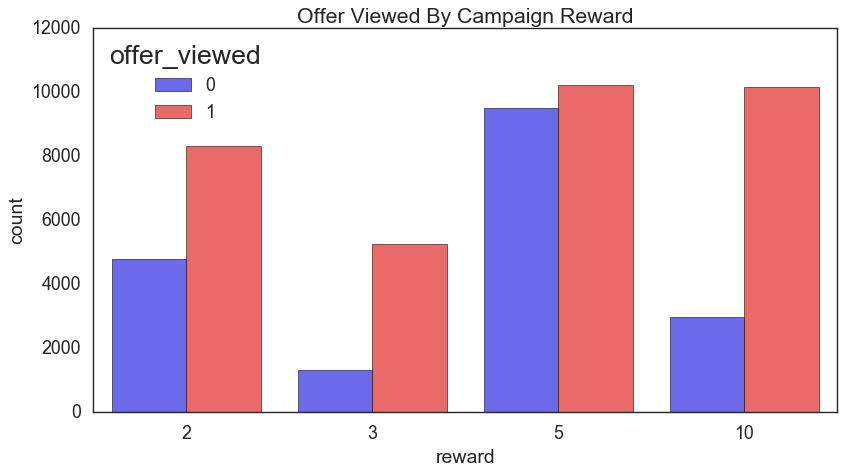

In [323]:
plt.figure(figsize=[12,6])
plt.title('Offer Viewed By Campaign Reward')
sns.countplot(x=df_merge.reward[df_merge['difficulty'] > 0], hue =df_merge.offer_viewed, palette='seismic')
plt.savefig('reward_viewed', bbox_inches='tight', dpi=600)

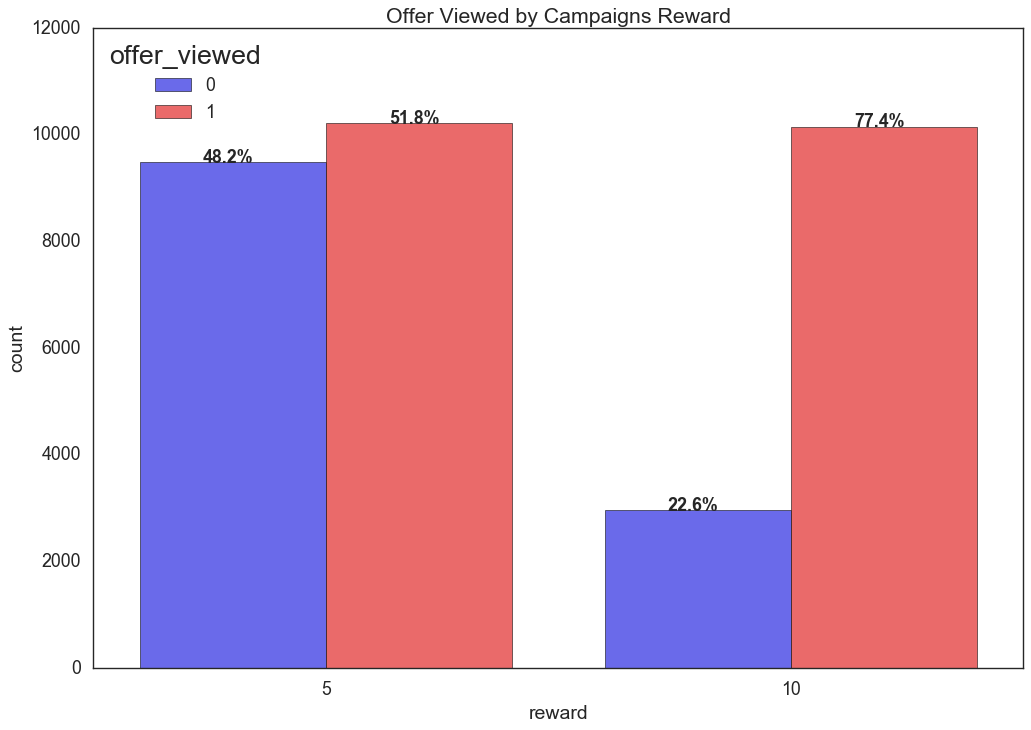

In [317]:
plt.figure(figsize=[15,10])
plt.title('Offer Viewed by Campaigns Reward')
ax = sns.countplot(x=df_merge.reward[df_merge['reward'] >= 5], hue =df_merge.offer_viewed, palette='seismic')
with_hue(ax,df_merge.reward[df_merge['reward'] >= 5],2,2,'reward_viewed.png')

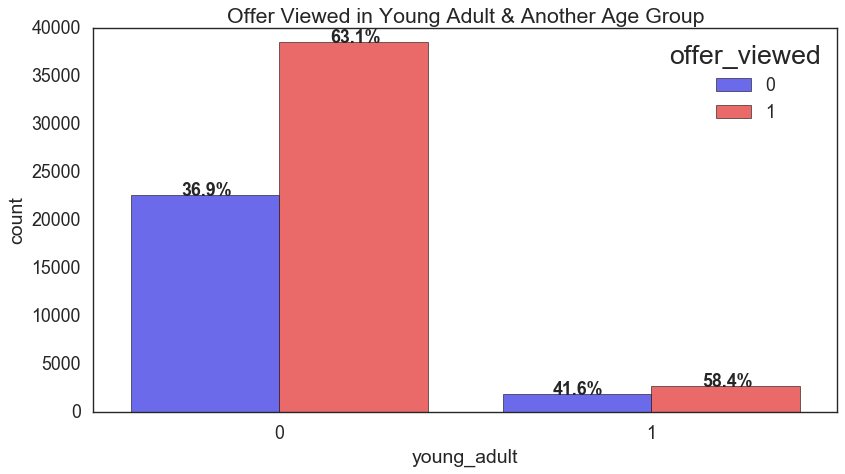

In [324]:
plt.figure(figsize=[12,6])
plt.title('Offer Viewed in Young Adult & Another Age Group')
ax = sns.countplot(x=df_merge.young_adult, hue =df_merge.offer_viewed, palette='seismic')
with_hue(ax,df_merge.young_adult,2,2,'young_adult_viewed.png')

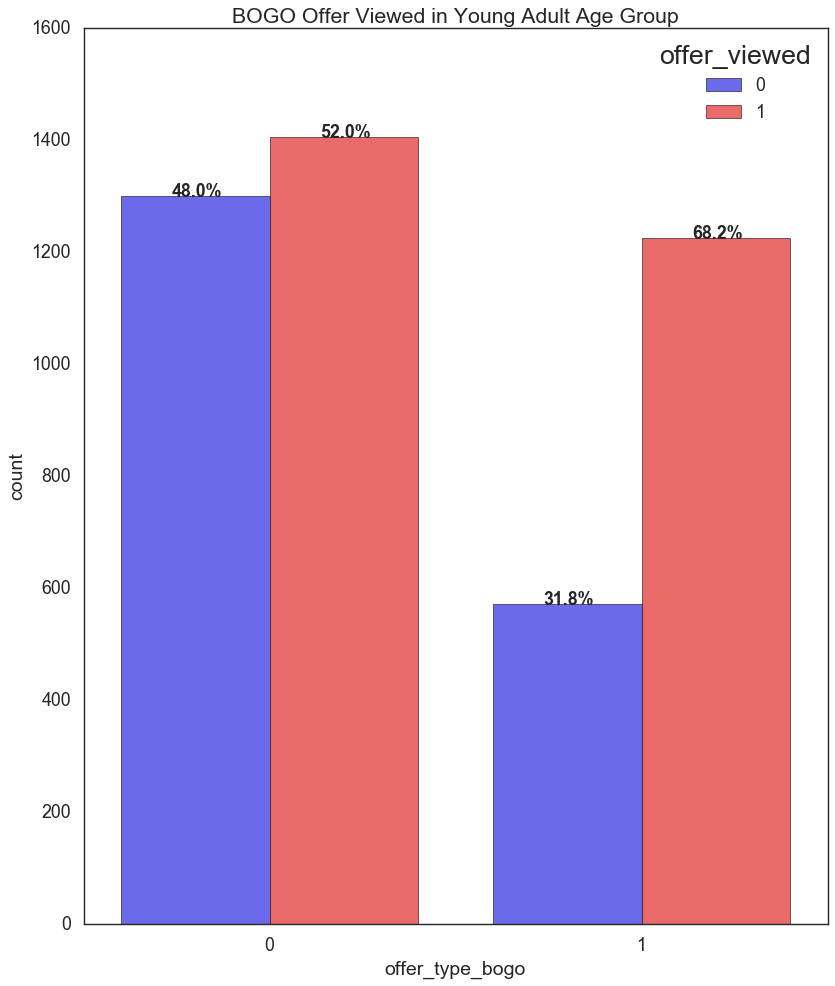

In [325]:
plt.figure(figsize=[12,14])
plt.title('BOGO Offer Viewed in Young Adult Age Group')
ax = sns.countplot(x=df_merge[df_merge['young_adult'] == 1].offer_type_bogo, hue =df_merge.offer_viewed, palette='seismic')
with_hue(ax,df_merge[df_merge['young_adult'] == 1].offer_type_bogo,2,2,'BOGO_young_adult_viewed.png')

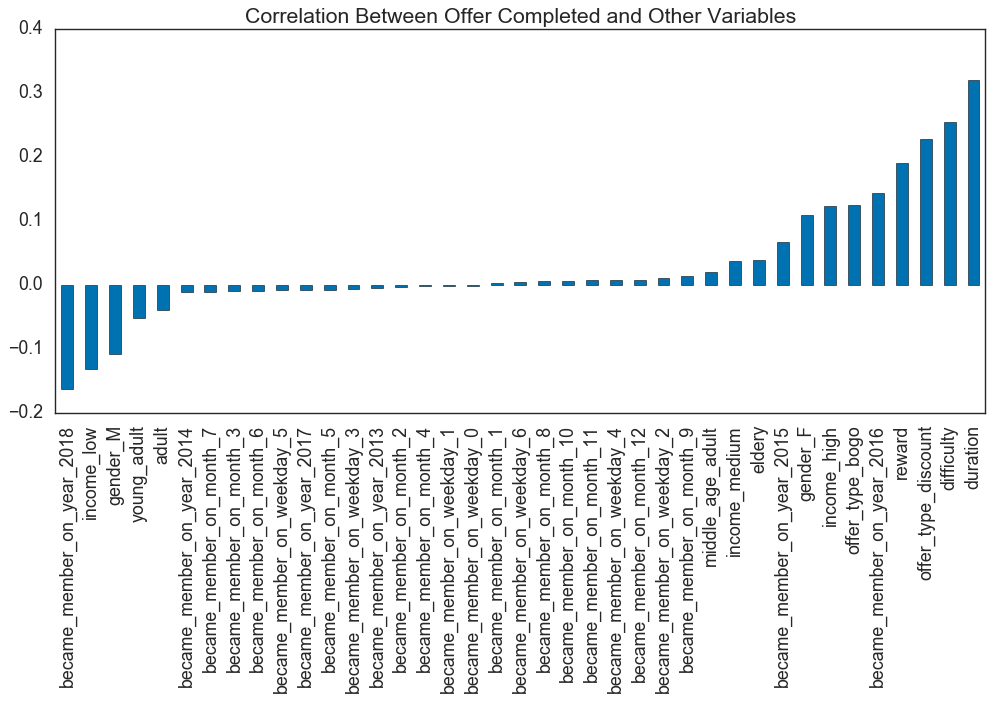

In [326]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,6])
plt.title('Correlation Between Offer Completed and Other Variables')
df_merge.drop(['offer_type_informational','email','web','mobile','offer_received','time_received','time_viewed','time_completed','customer_id','offer_id','offer_viewed','duration_expired'],axis=1)\
.corr()['offer_completed'].sort_values().drop('offer_completed').plot(kind='bar')
plt.savefig("correlation_completed.png", bbox_inches='tight', dpi=600)

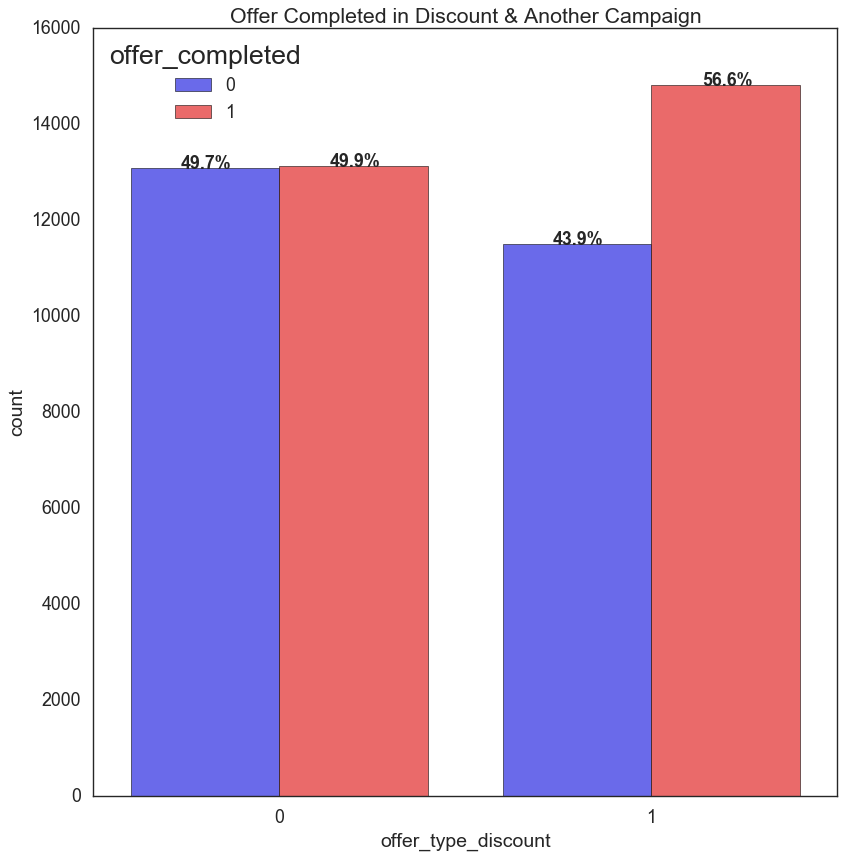

In [361]:
plt.figure(figsize=[12,12])
plt.title('Offer Completed in Discount & Another Campaign')
ax = sns.countplot(x=df_merge[df_merge['offer_type_informational'] == 0].offer_type_discount, hue =df_merge.offer_completed, palette='seismic')
with_hue(ax,df_merge[df_merge['offer_type_informational'] == 0].offer_type_discount,2,2,'discount_completed.png')

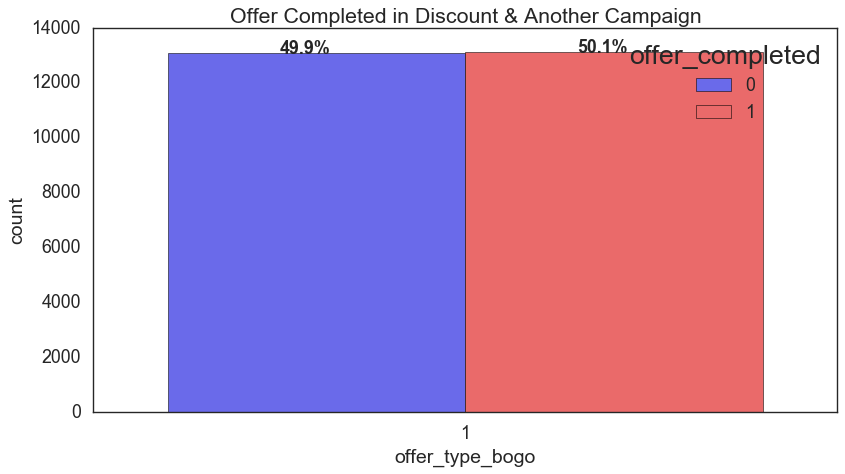

In [362]:
plt.figure(figsize=[12,6])
plt.title('Offer Completed in Discount & Another Campaign')
ax = sns.countplot(x=df_merge.offer_type_bogo[df_merge['offer_type_bogo'] == 1], hue =df_merge.offer_completed, palette='seismic')
without_hue(ax,df_merge.offer_type_bogo[df_merge['offer_type_bogo'] == 1],'bogo_completed.png')

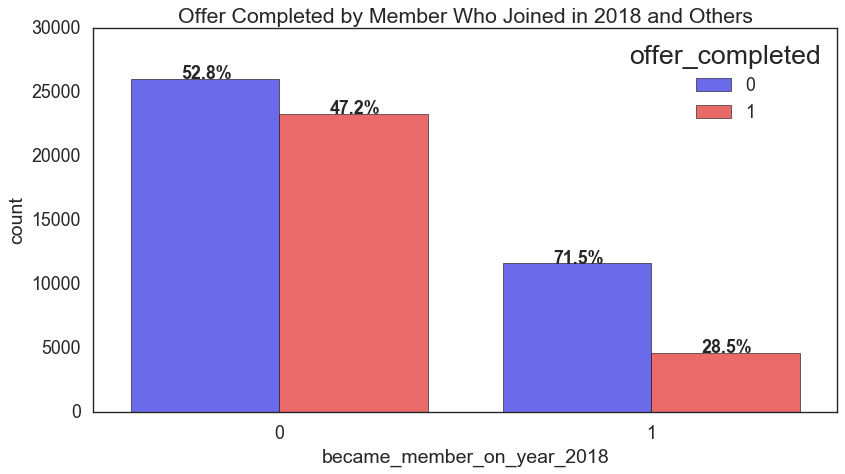

In [347]:
plt.figure(figsize=[12,6])
plt.title('Offer Completed by Member Who Joined in 2018 and Others')
ax = sns.countplot(x=df_merge.became_member_on_year_2018, hue =df_merge.offer_completed, palette='seismic')
with_hue(ax,df_merge.became_member_on_year_2018,2,2,'member_completed.png')

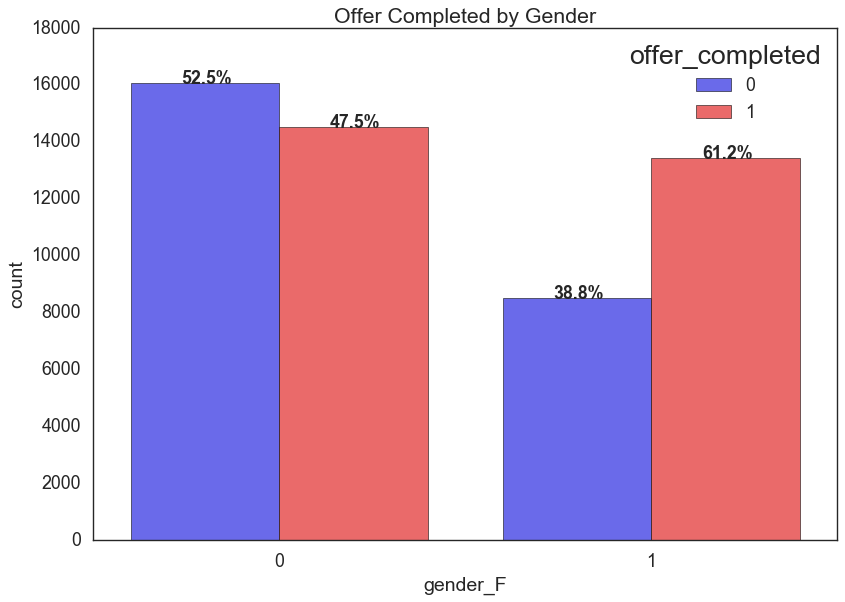

In [396]:
plt.figure(figsize=[12,8])
plt.title('Offer Completed by Gender')
ax = sns.countplot(x=df_merge.gender_F[(df_merge['offer_type_informational'] == 0)], hue =df_merge.offer_completed, palette='seismic')
with_hue(ax,df_merge.gender_F[(df_merge['offer_type_informational'] == 0)],2,2,'gender_completed.png')

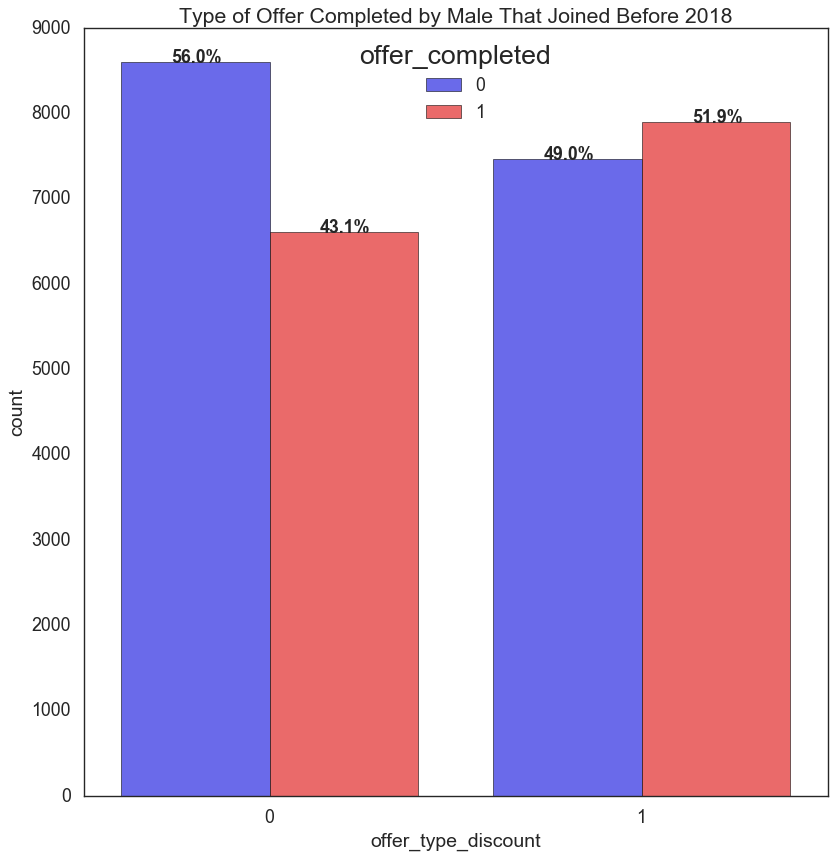

In [397]:
plt.figure(figsize=[12,12])
plt.title('Type of Offer Completed by Male That Joined Before 2018')
ax = sns.countplot(x=df_merge[(df_merge['gender_F'] == 0) & (df_merge['offer_type_informational'] == 0)].offer_type_discount, hue =df_merge.offer_completed, palette='seismic')
with_hue(ax,df_merge[(df_merge['gender_F'] == 0) & (df_merge['offer_type_informational'] == 0)].offer_type_discount,2,2,'men_type_completed.png')

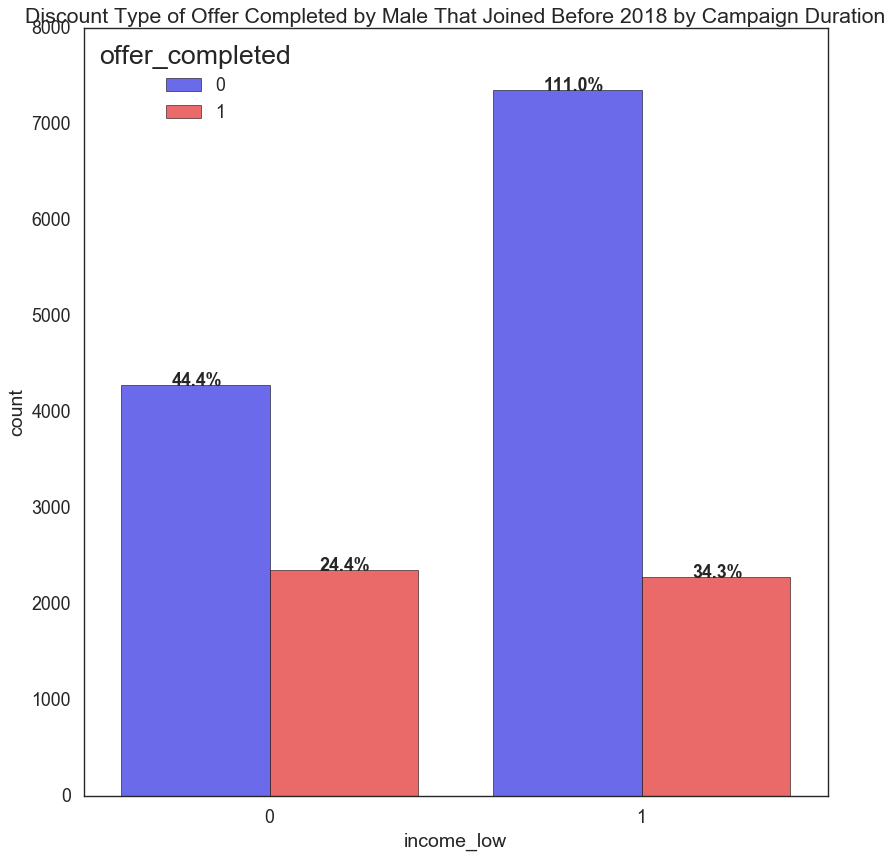

In [390]:
plt.figure(figsize=[12,12])
plt.title('Discount Type of Offer Completed by Male That Joined Before 2018 by Campaign Duration')
ax = sns.countplot(x=df_merge[(df_merge['became_member_on_year_2018'] == 1)].income_low, hue =df_merge.offer_completed, palette='seismic')
with_hue(ax,df_merge[(df_merge['became_member_on_year_2018'] == 1)].income_low,2,2,'test.png')

## Model

In [82]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [474]:
X = df_merge.drop(['email','offer_received','time_received','time_viewed','time_completed','customer_id','offer_id','offer_viewed','offer_completed','duration_expired'], axis=1)
y = df_merge[['offer_viewed','offer_completed']]

In [475]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=18)

In [473]:
y_train.groupby(['offer_viewed','offer_completed']).size() * 100/ (y_train.shape[0])

offer_viewed  offer_completed
0             0                  28.344312
              1                   8.882248
1             0                  29.112792
              1                  33.660649
dtype: float64

In [61]:
pipeline = Pipeline([
    ('clf', MultiOutputClassifier(GradientBoostingClassifier())) 
    ])

parameters = [
    {
    "clf": [MultiOutputClassifier(GradientBoostingClassifier())],
    'clf__estimator__learning_rate':[0.5, 0.25],
    'clf__estimator__n_estimators':[100, 200],
    },
    {
    "clf": [MultiOutputClassifier(RandomForestClassifier())],
    'clf__estimator__n_estimators': [100,200]
    }]


grid = GridSearchCV(pipeline, param_grid = parameters, cv=10, return_train_score=False)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        MultiOutputClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                                   criterion='friedman_mse',
                                                                                                   init=None,
                                                                                                   learning_rate=0.1,
                                                                                                   loss='deviance',
                                                                                                   max_depth=3,
                                                                                                   max_features=None,
                                                          

In [424]:
print(grid.best_estimator_.get_params()['clf'])
print('The best mean test score on the training dataset is {}'.format(grid.best_score_))

MultiOutputClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.25,
                                                           loss='deviance',
                                                           max_depth=3,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                         

In [476]:
y_pred = grid.predict(X_test)
label = ['Offer Viewed', 'Offer Completed']
report = classification_report(y_test, y_pred, output_dict=True, target_names=label)
confusion_matrix_viewed = multilabel_confusion_matrix(y_test, y_pred)[0]
accuracy_viewed = round(sum(confusion_matrix_viewed.diagonal())*100/confusion_matrix_viewed.sum(), 2)
recall_viewed = round(report['Offer Viewed']['recall']*100,2)
precision_viewed = round(report['Offer Viewed']['precision']*100,2)
confusion_matrix_completed = multilabel_confusion_matrix(y_test, y_pred)[1]
accuracy_completed = round(sum(confusion_matrix_completed.diagonal())*100/confusion_matrix_completed.sum(), 2)
recall_completed = round(report['Offer Completed']['recall']*100,2)
precision_completed = round(report['Offer Completed']['precision']*100,2)
print('The overall accuracy of the model on both class in the test dataset is {}%. Accuracy, recall and precision for offer viewed are {}%, {}% and {}%, \
while accuracy, recall and precision for offer completed are {}%, {}% and {}%.'.format(round(grid.score(X_test, y_test)*100,2),\
                                                                                   accuracy_viewed,recall_viewed,precision_viewed,\
                                                                                   accuracy_completed,recall_completed,precision_completed))

The overall accuracy of the model on both class in the test dataset is 53.85%. Accuracy, recall and precision for offer viewed are 71.03%, 80.39% and 75.13%, while accuracy, recall and precision for offer completed are 72.44%, 70.27% and 66.84%.


/Users/dhaneswaramandrasat/anaconda3/envs/dsnd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dhaneswaramandrasat/anaconda3/envs/dsnd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
import pickle
filename = 'model_classifer_final.pkl'
pickle.dump(grid, open(filename, 'wb'))

# Model 2: Transaction Prediction
In the last model, we have predicted whether particular demographic group will viewed or/and completed the offer that Starbucks sent to particular customer. 

In this section, we would like to know the effectiveness of the offer to demographic groups in relation to the average transactions. We would like to know in average how much they will spent after certain customer see an offer.

## Data Preparation

In [63]:
# get mean amount of transaction per customer during promotional duration

min_time = df_merge.groupby('customer_id')['time_received'].min().reset_index()
max_time = df_merge.groupby('customer_id')['duration_expired'].max().reset_index()
transaction_transf = transaction.merge(min_time, how='left',on='customer_id').merge(max_time, how='left',on='customer_id')

# filter the transaction only when the offer is active

transaction_transf = transaction_transf[(transaction_transf['time_transaction'] > transaction_transf['time_received']) & (transaction_transf['time_transaction'] < transaction_transf['duration_expired'])]
transaction_transf = transaction_transf.groupby('customer_id').mean()['amount'].reset_index()
transaction_transf

customer_id     amount
0                1  15.950000
1                2  24.905000
2                3  13.031000
3                4   2.685556
4                5   4.030000
...            ...        ...
14205        14609  52.816364
14206        14610   4.990000
14207        14611   2.696667
14208        14612   7.402500
14209        14613  15.071333

[14210 rows x 2 columns]

In [64]:
# merging the data
trans_merge = df_merge[df_merge['offer_viewed'] == 1].groupby(['customer_id','offer_id'])['offer_viewed'].mean().unstack().add_prefix('offer_id_').reset_index()
trans_merge[trans_merge.isna() == True] = 0
trans_merge = trans_merge.merge(profile, how='inner', on='customer_id')
trans_merge = trans_merge.merge(transaction_transf, how='inner', on='customer_id')
trans_merge

customer_id  offer_id_1  offer_id_2  offer_id_3  offer_id_4  \
0                1         0.0         0.0         0.0         1.0   
1                2         0.0         0.0         0.0         0.0   
2                3         0.0         1.0         0.0         0.0   
3                4         0.0         0.0         0.0         1.0   
4                5         0.0         0.0         0.0         0.0   
...            ...         ...         ...         ...         ...   
14032        14609         0.0         0.0         0.0         0.0   
14033        14610         0.0         0.0         0.0         0.0   
14034        14611         0.0         0.0         0.0         0.0   
14035        14612         0.0         0.0         0.0         0.0   
14036        14613         1.0         0.0         1.0         0.0   

       offer_id_5  offer_id_6  offer_id_7  offer_id_8  offer_id_9  ...  \
0             0.0         1.0         0.0         0.0         1.0  ...   
1             1.0         0.0         0.0         0.0         0.0  ...   
2             0.0         1.0         1.0         0.0         1.0  ...   
3             0.0         1.0         0.0         0.0         0.0  ...   
4             0.0         1.0         0.0         0.0         0.0  ...   
...           ...         ...         ...         ...         ...  ...   
14032         0.0         1.0         1.0         0.0         0.0  ...   
14033         1.0         0.0         0.0         1.0         0.0  ...   
14034         1.0         0.0         0.0         0.0         0.0  ...   
14035         0.0         1.0         1.0         0.0         1.0  ...   
14036         0.0         0.0         1.0         0.0         0.0  ...   

       young_adult  adult  middle_age_adult  eldery  income_low  \
0                0      1                 0       0           0   
1                0      0                 1       0           0   
2                1      0                 0       0           1   
3                0      1                 0       0           0   
4                1      0                 0       0           1   
...            ...    ...               ...     ...         ...   
14032            0      0                 0       1           0   
14033            0      0                 0       1           0   
14034            0      0                 0       1           1   
14035            0      1                 0       0           1   
14036            0      0                 1       0           1   

       income_medium  income_high  gender_F  gender_M     amount  
0                  1            0         0         1  15.950000  
1                  0            1         1         0  24.905000  
2                  0            0         1         0  13.031000  
3                  1            0         1         0   2.685556  
4                  0            0         1         0   4.030000  
...              ...          ...       ...       ...        ...  
14032              0            1         1         0  52.816364  
14033              1            0         0         1   4.990000  
14034              0            0         0         1   2.696667  
14035              0            0         0         1   7.402500  
14036              0            0         1         0  15.071333  

[14037 rows x 46 columns]

## Exploratory Data Analysis

In [65]:
trans_merge['amount'].describe()

count    14037.000000
mean        15.290048
std         18.188462
min          0.150000
25%          3.895714
50%         14.311000
75%         21.448333
max        666.860000
Name: amount, dtype: float64

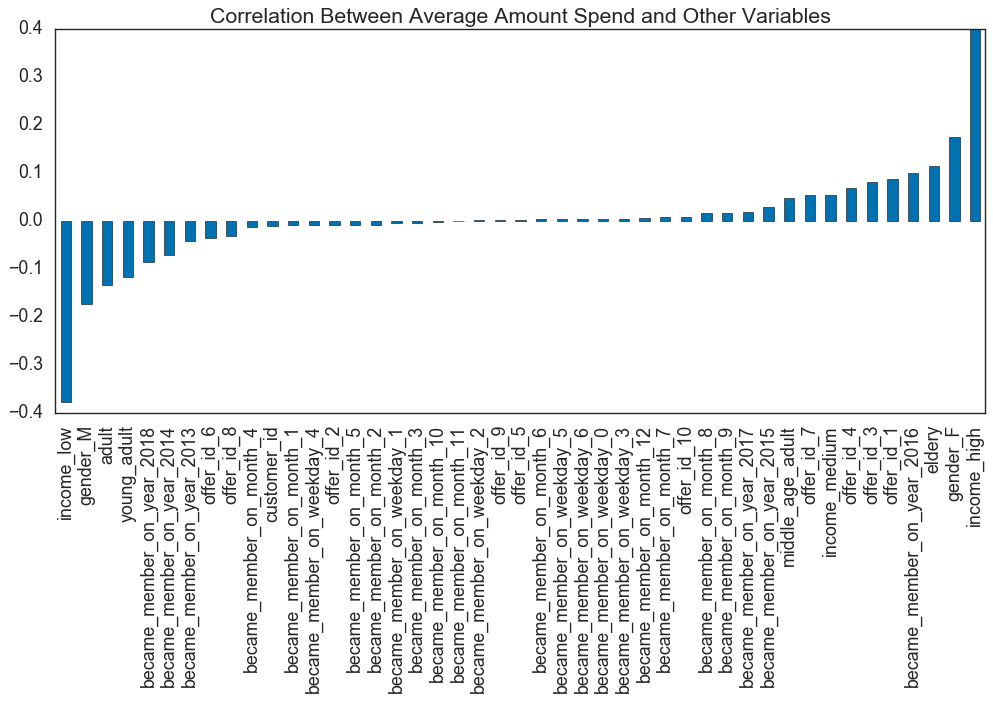

In [425]:
plt.figure(figsize=[15,6])
plt.title('Correlation Between Average Amount Spend and Other Variables')
trans_merge.corr()['amount'].sort_values().drop('amount').plot(kind='bar')
plt.savefig("correlation_spend.png", bbox_inches='tight', dpi=600)

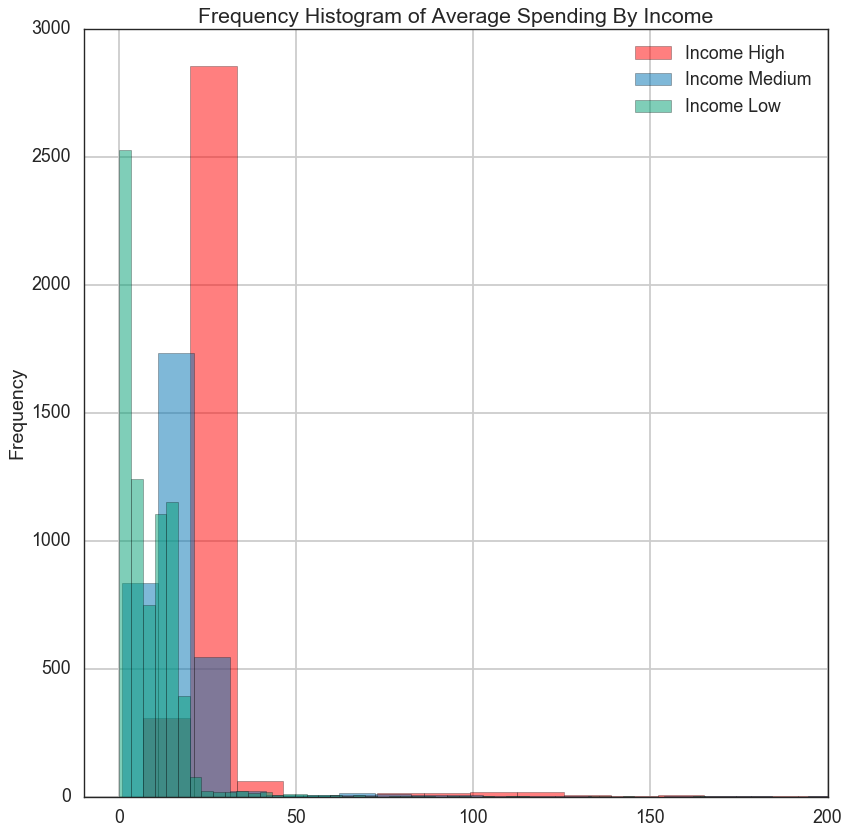

In [454]:
plt.figure(figsize=[12,12])
trans_merge[trans_merge['income_high'] == 1]['amount'].hist(alpha=0.5, bins=50, label = 'Income High', color='red')
trans_merge[trans_merge['income_medium'] == 1]['amount'].hist(alpha=0.5,bins=50, label = 'Income Medium')
trans_merge[trans_merge['income_low'] == 1]['amount'].hist(alpha=0.5,bins=50, label = 'Income Low')
plt.gca().set(title='Frequency Histogram of Average Spending By Income', ylabel='Frequency')
plt.xlim(-10,200)
plt.legend()
plt.savefig("histogram_income_spend.png", bbox_inches='tight', dpi=600)

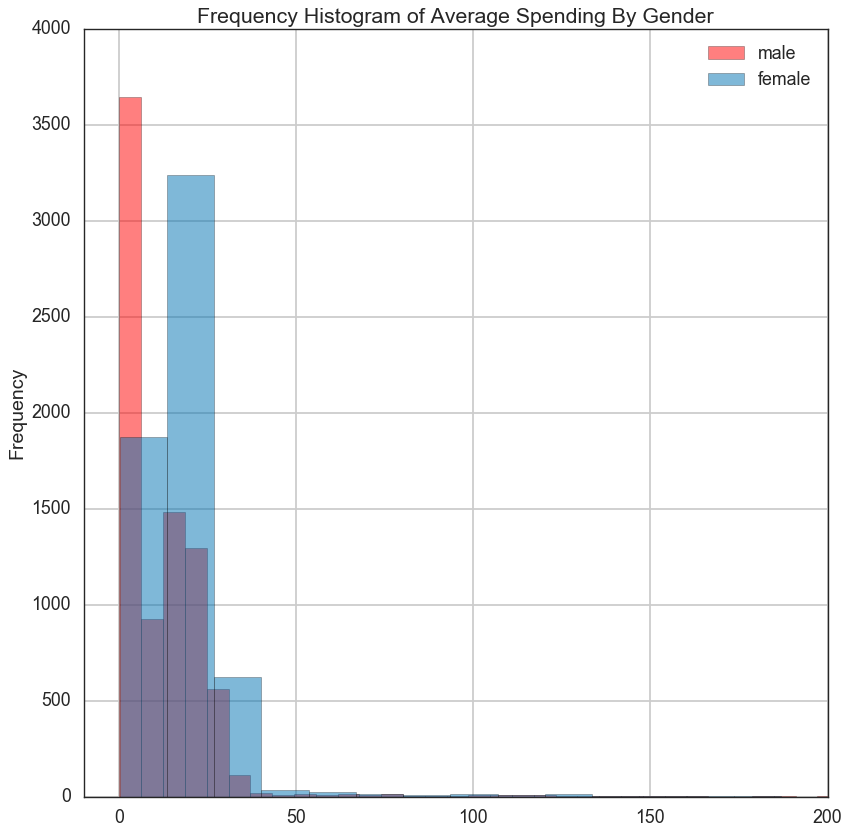

In [452]:
plt.figure(figsize=[12,12])
trans_merge[trans_merge['gender_M'] == 1]['amount'].hist(alpha=0.5, bins=50, label = 'male', color='red')
trans_merge[trans_merge['gender_M'] == 0]['amount'].hist(alpha=0.5,bins=50, label = 'female')
plt.gca().set(title='Frequency Histogram of Average Spending By Gender', ylabel='Frequency')
plt.xlim(-10,200)
plt.legend()
plt.savefig("histogram_gender_spend.png", bbox_inches='tight', dpi=600)

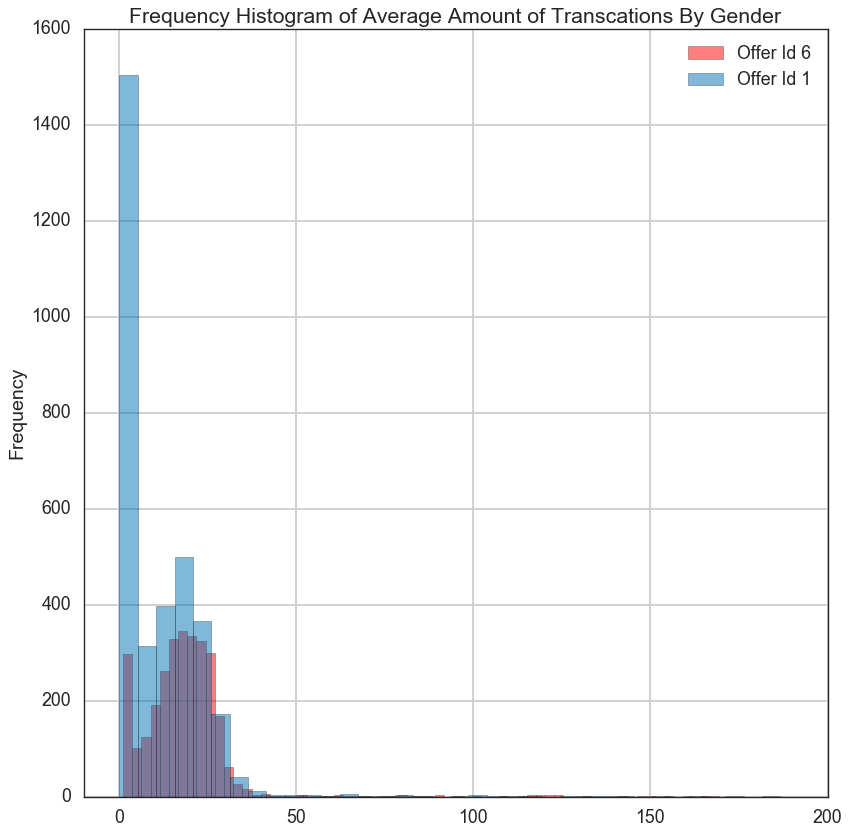

In [438]:
plt.figure(figsize=[12,12])
trans_merge[trans_merge['became_member_on_year_2016'] == 1]['amount'].hist(alpha=0.5, bins=100, label = 'Offer Id 6', color='red')
trans_merge[trans_merge['became_member_on_year_2018'] == 1]['amount'].hist(alpha=0.5,bins=100, label = 'Offer Id 1')
plt.gca().set(title='Frequency Histogram of Average Amount of Transcations By Gender', ylabel='Frequency')
plt.xlim(-10,200)
plt.legend()
plt.savefig("histogram_offer.png", bbox_inches='tight', dpi=600)

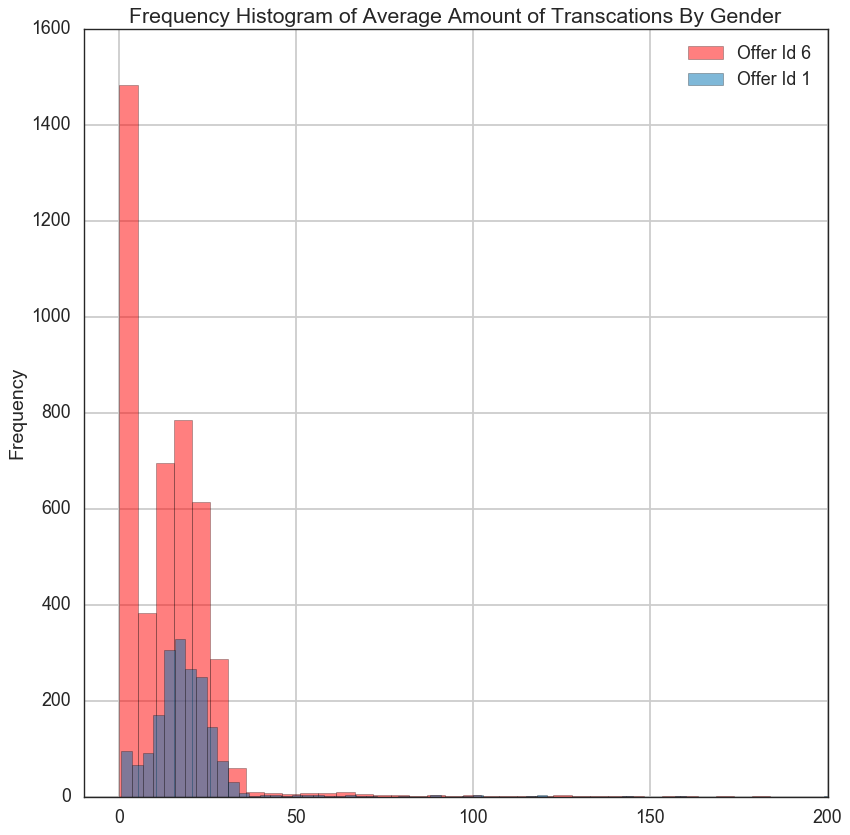

In [447]:
plt.figure(figsize=[12,12])
trans_merge[trans_merge['offer_id_6'] == 1]['amount'].hist(alpha=0.5, bins=100, label = 'Offer Id 6', color='red')
trans_merge[trans_merge['offer_id_1'] == 1]['amount'].hist(alpha=0.5,bins=100, label = 'Offer Id 1')
plt.gca().set(title='Frequency Histogram of Average Amount of Transcations By Gender', ylabel='Frequency')
plt.xlim(-10,200)
plt.legend()
plt.savefig("histogram_offer.png", bbox_inches='tight', dpi=600)

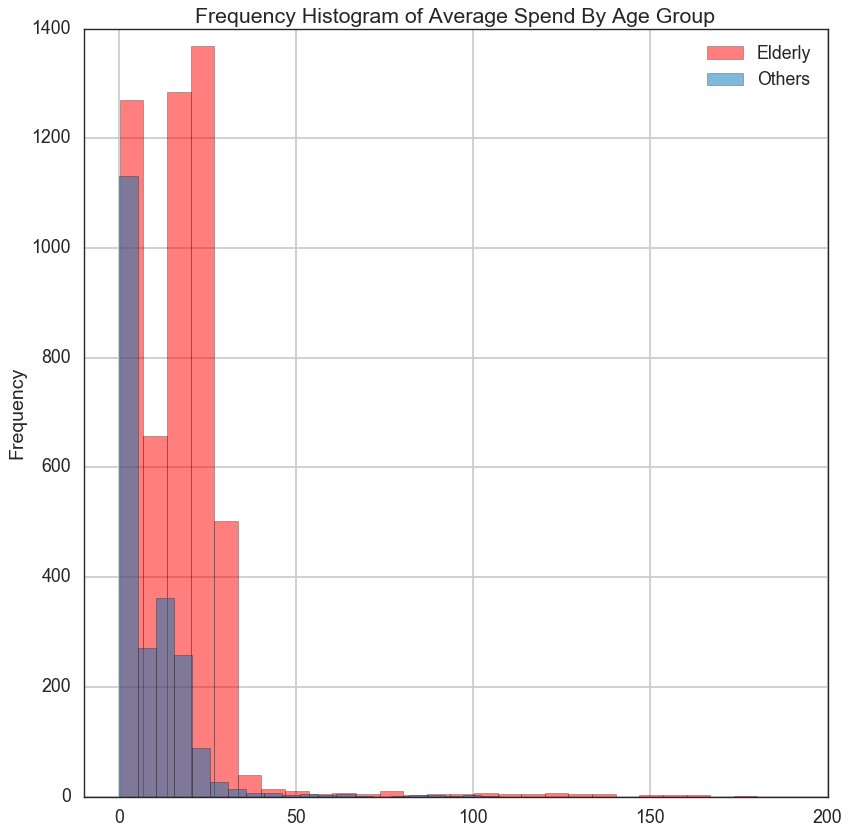

In [455]:
plt.figure(figsize=[12,12])
trans_merge[trans_merge['eldery'] == 1]['amount'].hist(alpha=0.5, bins=100, label = 'Elderly', color='red')
trans_merge[trans_merge['adult'] == 1]['amount'].hist(alpha=0.5,bins=100,label = 'Others')
plt.gca().set(title='Frequency Histogram of Average Spend By Age Group', ylabel='Frequency')
plt.xlim(-10,200)
plt.legend()
plt.savefig("histogram_age_spend.png", bbox_inches='tight', dpi=600)

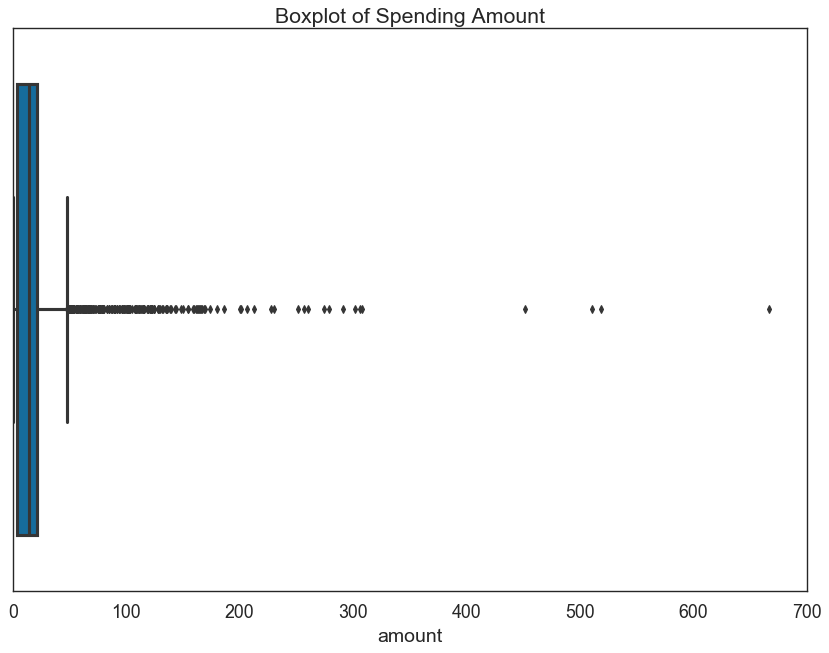

In [483]:
sns.boxplot(trans_merge['amount'])
plt.title('Boxplot of Spending Amount')
plt.savefig("boxplot_spend.png", bbox_inches='tight', dpi=600)

## Model

In [89]:
X = trans_merge.drop(['customer_id','amount'], axis=1)
y = trans_merge[['amount']]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=19)

In [90]:
pipeline = Pipeline([
    ('clr', GradientBoostingRegressor()) 
    ])

parameters = [
    {
    "clr": [GradientBoostingRegressor()],
    'clr__learning_rate':[0.5, 0.25, 0.1],
    'clr__n_estimators':[100, 200,300],
    'clr__max_depth':[10,20,50]
    },
    {
    "clr": [RandomForestRegressor()],
    'clr__n_estimators': [100,200, 300],
    'clr__max_depth':[10,20,50],
    'clr__min_samples_split':[2, 5, 10]
    }]


grid_amount = GridSearchCV(pipeline, param_grid = parameters, cv=10, return_train_score=False)

grid_amount.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clr',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                                  max_depth=3,
                                                                  max_features=None,
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                      

In [463]:
print(grid_amount.best_estimator_.get_params()['clr'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [91]:
import pickle
filename = 'model_regressor_final.pkl'
pickle.dump(grid_amount, open(filename, 'wb'))

In [462]:
y_pred = grid_amount.predict(X_test)
y_pred_train = grid_amount.predict(X_train)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(y_train, y_pred_train))
print(mean_squared_error(y_train, y_pred_train))
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

5.521851962672102
186.79110637413407
6.331137592215777
279.5189275677207
